### ML Project

Student: Abdukholik Tukhtamishev, id: 474886
 Algorithms I will be considering: Logistic rregression, KNN, Lasso, Ridge

In [2]:
# Libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

In [3]:
# Setting the working directory
os.chdir("E:/UWarsaw/Semester_II/ML/Project/_assessment_project")

In [4]:
# Uploading the data
insurance_train = pd.read_csv("data/insurance_train.csv")
insurance_test = pd.read_csv('data/insurance_test.csv')

insurance_train.head() # Dependent variable is in the train data "claim_status"

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,9b2d5b46,type_a,web,0,agt_0001,0.207538,96d6c6df,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.300461,50b3e71e,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48


#### EDA

In [5]:
# Main information about the variables and the structure of the dataset 
insurance_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


In [6]:
# Checking if there is any missing data 
print(insurance_train.isna().sum().sort_values(ascending = True))

reward                  0
claim_status            0
person_gender           0
entity_type             0
channel                 0
support_interactions    0
agent_id                0
customer_score          0
entity_a                0
person_age              0
location                0
revenue                 0
product_id              0
trip_length             0
dtype: int64


In [7]:
# Checking the dublicates
duplicate_count = insurance_train.duplicated().sum()
duplicate_count

np.int64(0)

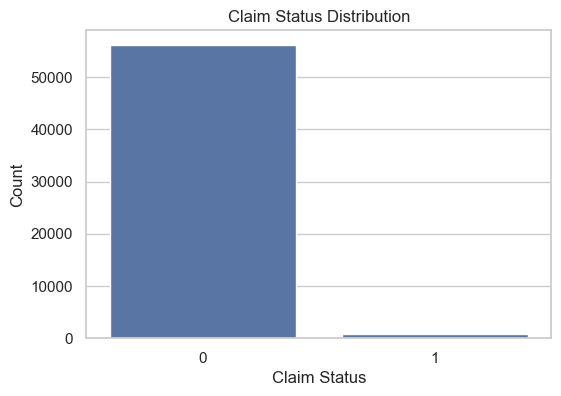

In [8]:
# Setting plot style
sns.set(style="whitegrid")

# 1. Bar chart of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='claim_status', data=insurance_train)
plt.title('Claim Status Distribution')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()

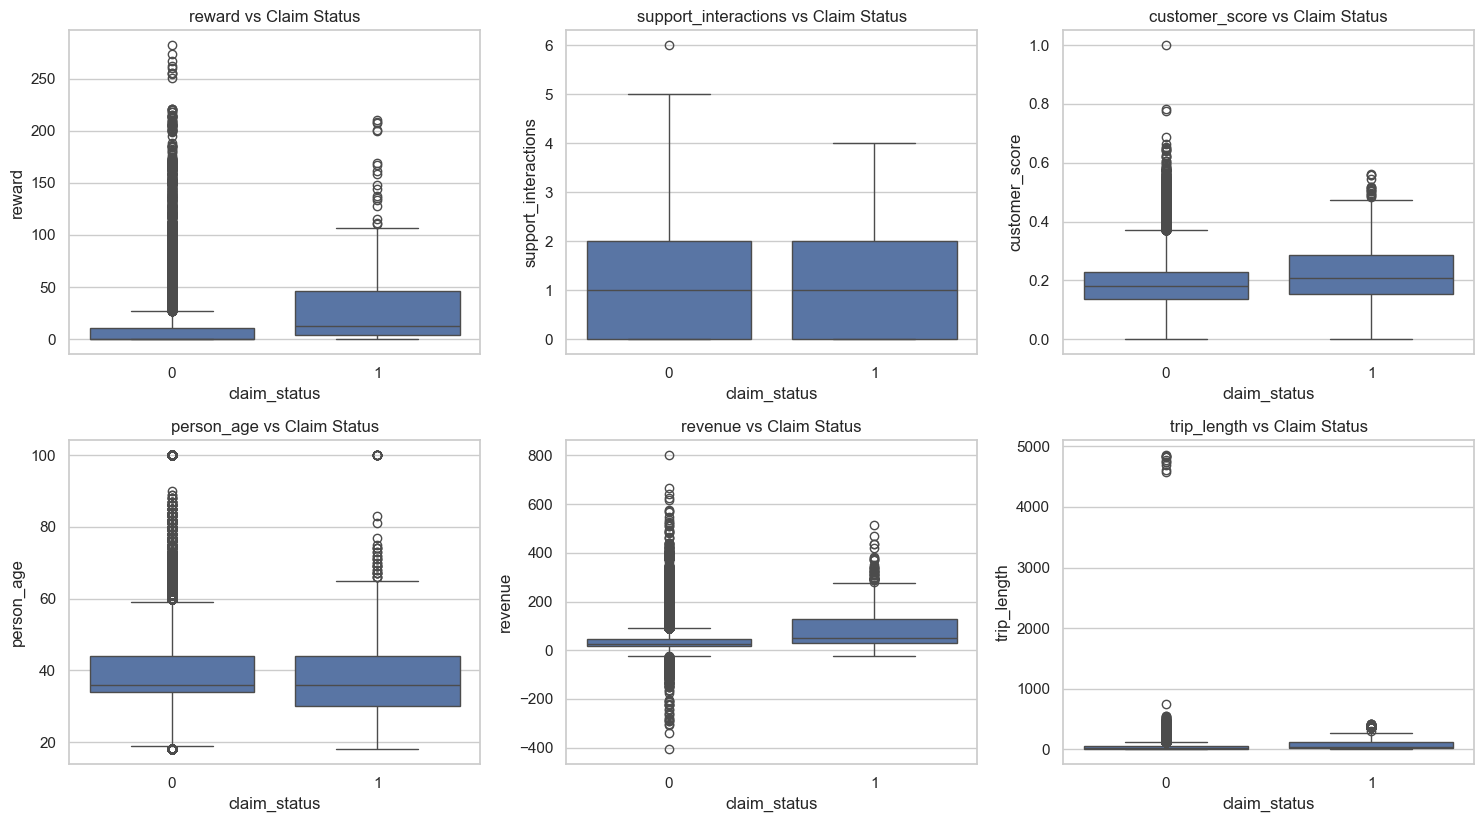

In [9]:
# 2. Boxplots of numerical features grouped by claim_status
numerical_features = insurance_train.select_dtypes(include=['int64', 'float64']).columns.drop('claim_status')
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='claim_status', y=col, data=insurance_train)
    plt.title(f'{col} vs Claim Status')
plt.tight_layout()
plt.show()

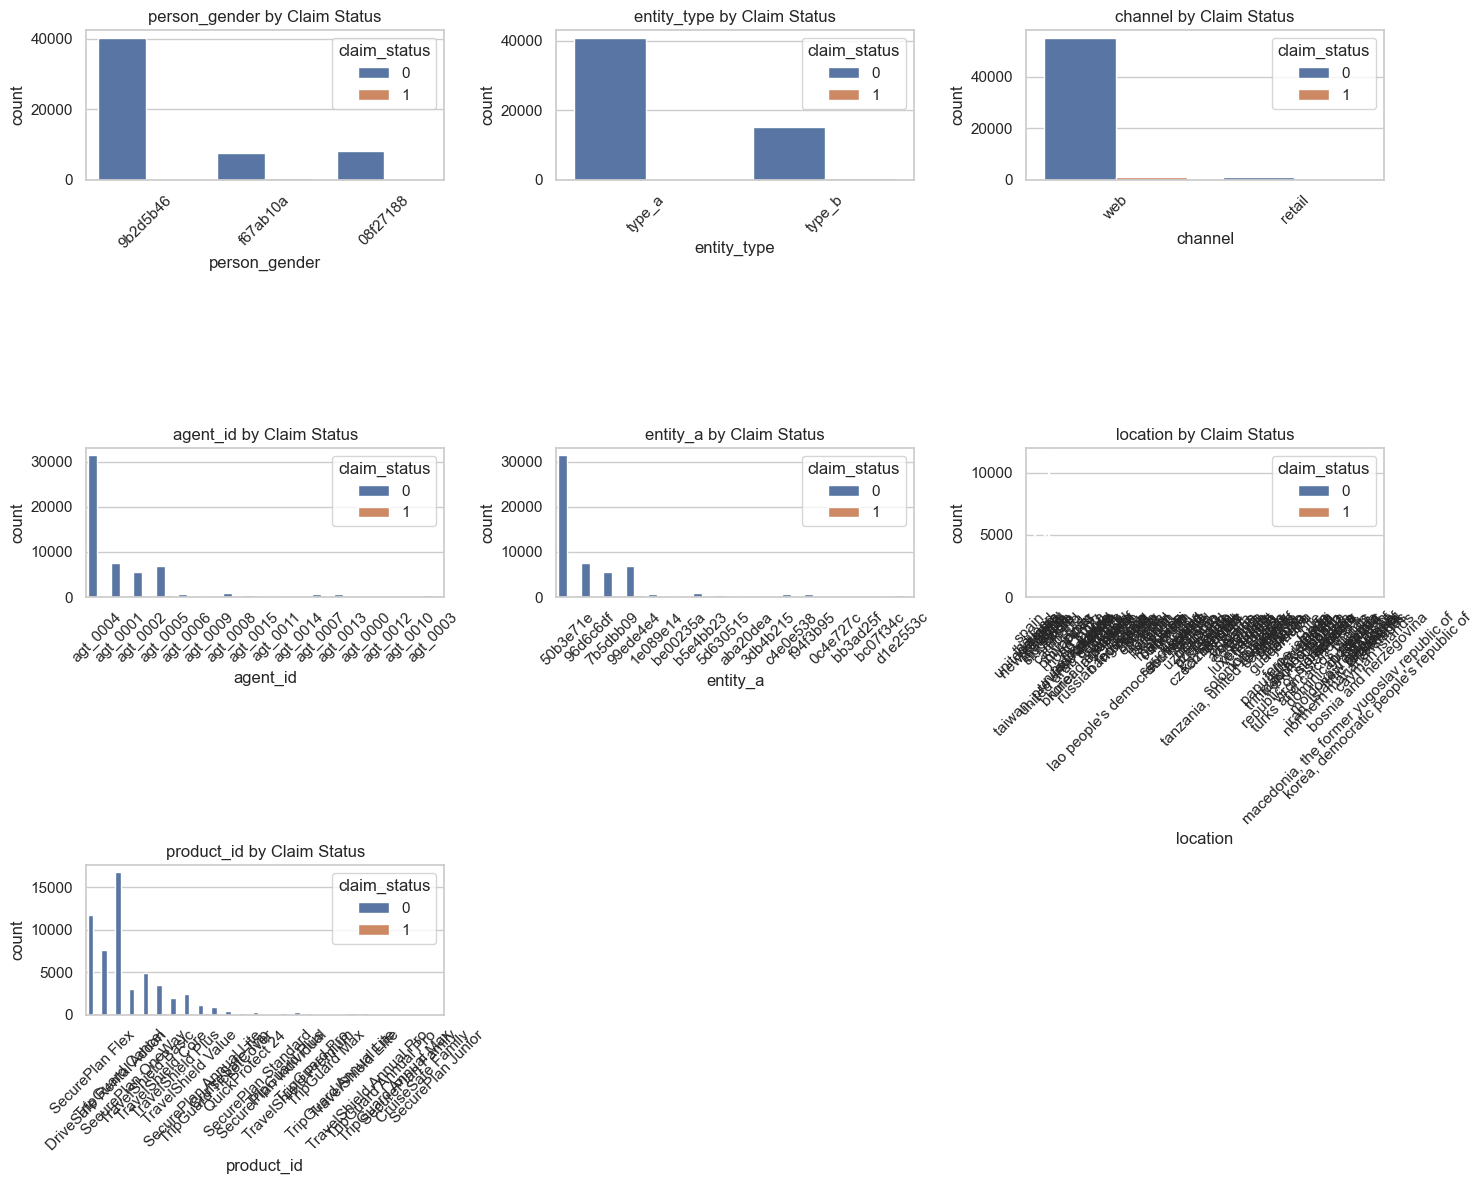

In [10]:
# 3. Count plots of categorical features grouped by claim_status
categorical_features = insurance_train.select_dtypes(include='object').columns
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='claim_status', data=insurance_train)
    plt.title(f'{col} by Claim Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

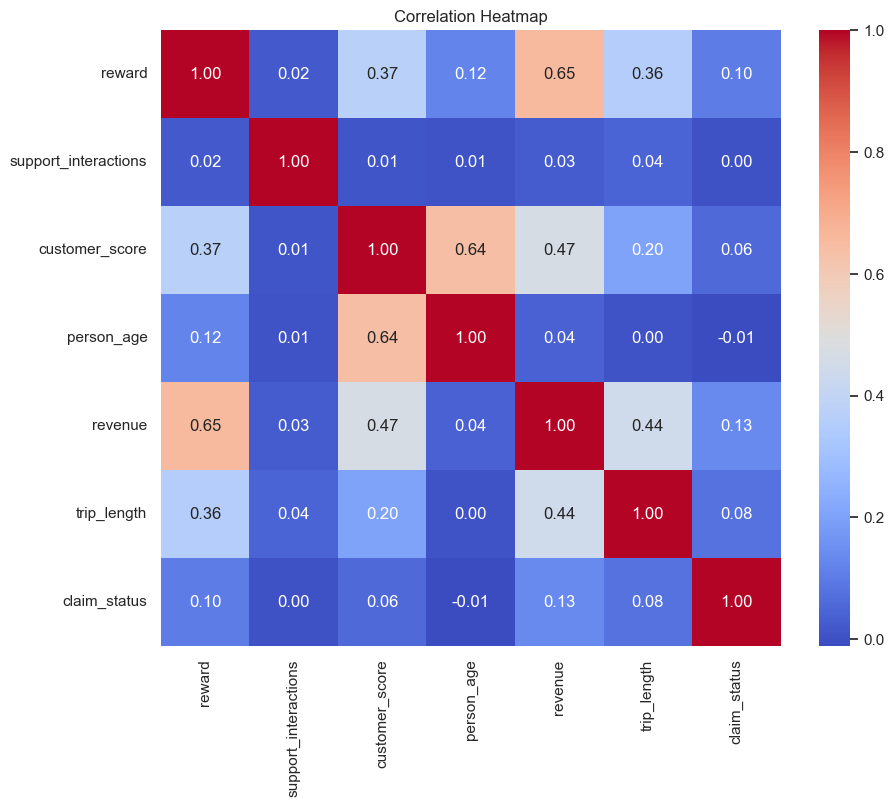

In [11]:
# 4. Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
corr_matrix = insurance_train[numerical_features.to_list() + ['claim_status']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The features show weak correlation with `claim_status`, with the highest being `revenue` at 0.13. There is a moderate correlation between `reward` and `revenue` (0.65), and between `customer_score` and both `person_age` (0.64) and `revenue` (0.47). `Support_interactions` shows no meaningful correlation with any variable.


### Encoding part


For algorithms to work, our data should be numeric.

In [12]:
# Unique values in each column 
unique_values_per_column = insurance_train.nunique().sort_values(ascending=False)
unique_values_per_column

customer_score          56862
revenue                 55300
reward                  25246
trip_length               448
location                  146
person_age                 74
product_id                 26
entity_a                   16
agent_id                   16
support_interactions        7
person_gender               3
channel                     2
claim_status                2
entity_type                 2
dtype: int64

In [13]:
# Dropping 3 columns as they have no predicting power
insurance_train = insurance_train.drop(columns=['person_gender', 'entity_a', 'agent_id'])
insurance_test = insurance_test.drop(columns=['person_gender', 'entity_a', 'agent_id'])
insurance_train.head()

,reward,claim_status,entity_type,channel,support_interactions,customer_score,person_age,location,revenue,product_id,trip_length
0,0.000000,0,type_a,web,0,0.284509,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,type_a,web,0,0.207538,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,type_a,web,1,0.300461,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,type_a,web,0,0.132404,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,type_a,web,2,0.070443,37,viet nam,10.476416,TripGuard Cancel,48


In [14]:
# checking and preparing for the encoding 
unique_values = insurance_train.nunique().sort_values(ascending=False)
unique_values

customer_score          56862
revenue                 55300
reward                  25246
trip_length               448
location                  146
person_age                 74
product_id                 26
support_interactions        7
claim_status                2
entity_type                 2
channel                     2
dtype: int64

In [15]:

print(insurance_train['channel'].unique())
print(insurance_test['channel'].unique())
print(insurance_train['entity_type'].unique())
print(insurance_test['entity_type'].unique())


['web' 'retail']
['web' 'retail']
['type_a' 'type_b']
['type_a' 'type_b']


It turns out that both on the train and the test data `channel` and `entity_type` variables have 2 cardinality on which we can apply binomial encoding  

Ordinal Encoding Variables: `entity_type`, `channel`


In [16]:
# For 'channel'
channel_mapping = {'web': 0, 'retail': 1}
insurance_train['channel'] = insurance_train['channel'].map(channel_mapping)
insurance_test['channel'] = insurance_test['channel'].map(channel_mapping)

# For 'entity_type'
entity_type_mapping = {'type_a': 0, 'type_b': 1}
insurance_train['entity_type'] = insurance_train['entity_type'].map(entity_type_mapping)
insurance_test['entity_type'] = insurance_test['entity_type'].map(entity_type_mapping)


In [17]:
insurance_train.head()

,reward,claim_status,entity_type,channel,support_interactions,customer_score,person_age,location,revenue,product_id,trip_length
0,0.000000,0,0,0,0,0.284509,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,0,0,0,0.207538,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,0,0,1,0.300461,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,0,0,0,0.132404,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,0,0,2,0.070443,37,viet nam,10.476416,TripGuard Cancel,48


### Label encoding 

In [18]:
# remaining columns that needs to be encoded
print(insurance_train['location'].unique())
print(insurance_test['location'].unique())
print(insurance_train['product_id'].unique())
print(insurance_test['product_id'].unique())


['united states' 'spain' 'new zealand' 'thailand' 'viet nam' 'australia'
 'croatia' 'malaysia' 'indonesia' 'singapore' 'brazil' 'china'
 'taiwan, province of china' 'cambodia' 'india' 'finland' 'philippines'
 'myanmar' 'united arab emirates' 'hong kong' 'united kingdom' 'japan'
 'netherlands' 'sri lanka' 'switzerland' 'brunei darussalam'
 'korea, republic of' 'austria' 'turkey' 'france' 'denmark'
 'russian federation' 'greece' 'romania' 'germany' 'canada' 'israel'
 'bangladesh' 'macao' 'peru' 'mongolia' "lao people's democratic republic"
 'kenya' 'cyprus' 'nepal' 'ukraine' 'ethiopia' 'serbia' 'uganda' 'italy'
 'portugal' 'belgium' 'sweden' 'qatar' 'maldives' 'pakistan' 'colombia'
 'bahrain' 'mexico' 'saudi arabia' 'jordan' 'south africa' 'norway' 'fiji'
 'iceland' 'kuwait' 'namibia' 'uzbekistan' 'poland' 'morocco' 'zambia'
 'azerbaijan' 'puerto rico' 'czech republic' 'ireland' 'kazakhstan'
 'reunion' 'vanuatu' 'guam' 'hungary' 'georgia' 'egypt'
 'tanzania, united republic of' 'bulgaria

In [19]:
# Instantiate the encoder for both columns
target_enc = ce.TargetEncoder(cols=['location', 'product_id'])

# Fit on training data
insurance_train[['location', 'product_id']] = target_enc.fit_transform(
    insurance_train[['location', 'product_id']], insurance_train['claim_status']
)

# Transform test data
insurance_test[['location', 'product_id']] = target_enc.transform(
    insurance_test[['location', 'product_id']]
)


In [20]:
insurance_train.head(10)

,reward,claim_status,entity_type,channel,support_interactions,customer_score,person_age,location,revenue,product_id,trip_length
0,0.000000,0,0,0,0,0.284509,51,0.013919,105.459587,0.010529,21
1,18.428627,0,0,0,0,0.207538,32,0.016234,30.433459,0.009983,6
2,0.000000,0,0,0,1,0.300461,38,0.008299,78.728474,0.002382,84
3,0.000000,0,0,0,0,0.132404,30,0.006034,17.146843,0.002382,39
4,0.000000,0,0,0,2,0.070443,37,0.007422,10.476416,0.002382,48
5,41.613029,0,0,0,1,0.288280,30,0.010232,68.698795,0.009983,59
6,46.687680,0,0,0,1,0.140587,23,0.000631,79.426319,0.009983,37
7,0.000000,0,0,0,1,0.189089,38,0.003735,20.088002,0.002670,18
8,10.186860,0,1,0,1,0.097472,35,0.004828,28.631036,0.004477,10
9,9.335454,0,1,0,2,0.083457,28,0.042371,37.609526,0.052516,138


In [21]:
insurance_test.head(10)

,reward,entity_type,channel,support_interactions,customer_score,person_age,location,revenue,product_id,trip_length
0,84.316320,0,0,2,0.009257,31,0.000002,-141.716239,0.009983,73
1,45.884363,0,0,0,0.108049,29,0.010232,82.225268,0.009983,25
2,0.000000,0,0,2,0.108814,26,0.004828,10.247118,0.002382,6
3,29.363482,1,0,1,0.215505,32,0.013889,83.483247,0.007812,73
4,12.440951,1,0,0,0.194798,26,0.042371,46.679372,0.061054,32
5,10.554589,0,1,1,0.318590,59,0.006034,29.677038,0.002198,7
6,23.032416,0,0,0,0.260454,34,0.008299,37.670204,0.009983,71
7,0.593061,1,0,1,0.196252,48,0.042371,2.190958,0.006322,3
8,6.348724,1,0,1,0.190387,52,0.006034,17.234293,0.004477,14
9,6.527074,1,0,2,0.175124,37,0.004828,17.992485,0.004477,163


In [22]:

# Preparing features and target from insurance_train
X = insurance_train.drop(columns=['claim_status'])
y = insurance_train['claim_status']

# Internal split: train (60%), validation (20%), test (20%)
X_temp, X_internal_test, y_temp, y_internal_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_internal_train, X_internal_val, y_internal_train, y_internal_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
# Now: 60% train, 20% val, 20% test

# Scaling
scaler = StandardScaler()
X_internal_train_scaled = scaler.fit_transform(X_internal_train)
X_internal_val_scaled = scaler.transform(X_internal_val)
X_internal_test_scaled = scaler.transform(X_internal_test)


Main classifying algorithms 



In [23]:

# Defining models and parameter grids
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'RidgeClassifier': RidgeClassifier(random_state=42, class_weight='balanced'),
    'LassoLogisticRegression': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')
}

param_grids = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 100]},
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'RidgeClassifier': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'LassoLogisticRegression': {'C': [0.01, 0.1, 1, 10, 100]}
}

# Hyperparameter tuning and validation
best_estimators = {}
validation_scores = {}

for model_name in models:
    print(f"\nTraining and tuning {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_internal_train_scaled, y_internal_train)
    best_estimators[model_name] = grid_search.best_estimator_
    y_val_pred = grid_search.predict(X_internal_val_scaled)
    val_bal_acc = balanced_accuracy_score(y_internal_val, y_val_pred)
    validation_scores[model_name] = val_bal_acc
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Validation balanced accuracy: {val_bal_acc:.4f}")

# Selecting best model based on validation balanced accuracy
best_model_name = max(validation_scores, key=validation_scores.get)
best_model = best_estimators[best_model_name]
print(f"\nBest model: {best_model_name} with validation balanced accuracy: {validation_scores[best_model_name]:.4f}")

# Final evaluation on internal test set
y_test_pred = best_model.predict(X_internal_test_scaled)
test_bal_acc = balanced_accuracy_score(y_internal_test, y_test_pred)
print(f"Internal test balanced accuracy: {test_bal_acc:.4f}")

# (Optional) Retraining best model on train+val for final predictions
X_trainval = np.vstack([X_internal_train_scaled, X_internal_val_scaled])
y_trainval = np.concatenate([y_internal_train, y_internal_val])
best_model.fit(X_trainval, y_trainval)
# Using best_model to predict on insurance_test_scaled for submission



Training and tuning LogisticRegression...
Best parameters for LogisticRegression: {'C': 0.01}
Validation balanced accuracy: 0.7004

Training and tuning KNN...
Best parameters for KNN: {'n_neighbors': 3}
Validation balanced accuracy: 0.5137

Training and tuning RidgeClassifier...
Best parameters for RidgeClassifier: {'alpha': 100.0}
Validation balanced accuracy: 0.7001

Training and tuning LassoLogisticRegression...
Best parameters for LassoLogisticRegression: {'C': 0.1}
Validation balanced accuracy: 0.6971

Best model: LogisticRegression with validation balanced accuracy: 0.7004
Internal test balanced accuracy: 0.7862


LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [26]:
# After making predictions on your test data
pd.DataFrame({'prediction': y_test_pred}).to_csv('test_predictions.csv', index=False)


### Conclusion

After evaluating four classification algorithms-Logistic Regression, K-Nearest Neighbors (KNN), Ridge Classifier, and Lasso Logistic Regression-using balanced accuracy as the main metric, Logistic Regression emerged as the best-performing model. Hyperparameter tuning was conducted for each algorithm, and model selection was based on performance on an internal validation set. Logistic Regression, with a regularization parameter C=0.01, achieved the highest validation balanced accuracy of 0.7004. When evaluated on the internal test set, this model reached a balanced accuracy of 0.7862, indicating strong and robust performance in distinguishing between the two classes, even in the presence of significant class imbalance.

This result demonstrates that Logistic Regression, especially when combined with appropriate regularization and class weighting, is well-suited for the insurance claim classification problem. The model's ability to generalize was confirmed by its improved performance on the internal test set, suggesting that it did not overfit during training or validation. Based on these findings, Logistic Regression was selected as the final model for generating predictions on the external test data.